In [1]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Functions

In [2]:
def kriging(x, X, Y, sigma, cov):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    cov : covariance function cov(h) 
    '''
    return cov(cdist(x, X)) @ np.linalg.solve(sigma, Y)

In [3]:
def nestedKriging(x, X, Y, A, cov):
    '''
    x : prediction point
    X : the vector of all observation points
    Y : all observations
    A : list of list with submodels indexes
    cov : covariance function cov(h) 
    '''
    M = np.zeros((len(A),1))
    k_M = np.zeros((len(A),1))
    K_M = np.zeros((len(A),len(A)))

    for i in range(len(A)):
        k_x_X_i = np.nan_to_num(cov(cdist(x, X[A[i],:])), nan=1)
        k_X_X_i = np.nan_to_num(cov(cdist(X[A[i],:], X[A[i],:])), nan=1)
        
        M[i] = k_x_X_i @ np.linalg.solve(k_X_X_i, Y[A[i]])
        k_M[i] = k_x_X_i @ np.linalg.solve(k_X_X_i, k_x_X_i.T)
        
        for j in range(i+1, len(A)):
            k_x_X_j = np.nan_to_num(cov(cdist(x, X[A[j],:])), nan=1)
            k_X_X_j = np.nan_to_num(cov(cdist(X[A[j],:], X[A[j],:])), nan=1)
            k_X_i_X_j = np.nan_to_num(cov(cdist(X[A[i],:], X[A[j],:])), nan=1)
            
            K_M[i,j] = np.linalg.solve(k_X_X_i, k_x_X_i.T).T @ k_X_i_X_j @ np.linalg.solve(k_X_X_j, k_x_X_j.T)    
    
    K_M = K_M + K_M.T
    np.fill_diagonal(K_M, k_M)
    
    return k_M.T @ np.linalg.solve(K_M, M)

In [4]:
def scatterplot(X,Y,title='',xlabel='',ylabel=''):
    plt.scatter(X,Y)
    plt.plot([min(min(X), min(Y)), max(max(X), max(Y))], [min(min(X), min(Y)), max(max(X), max(Y))], ls = '--', lw = 2, c = 'r')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

Matérn con $K_\nu$

In [5]:
matern_model = lambda t, nu: np.vectorize(lambda x: 2**(1-nu) / gamma(nu) * (t*x)**nu * kv(nu, t*x))

Observation points

In [22]:
d = 2
n = 100
sup = 20
X = np.random.uniform(0, sup, (n,d))

Parameters

In [23]:
nu = 3/2
theta = 1

Models

In [24]:
cov = matern_model(theta, nu)

In [25]:
sigma = np.nan_to_num(cov(cdist(X, X)), nan=1)

In [26]:
Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, n)

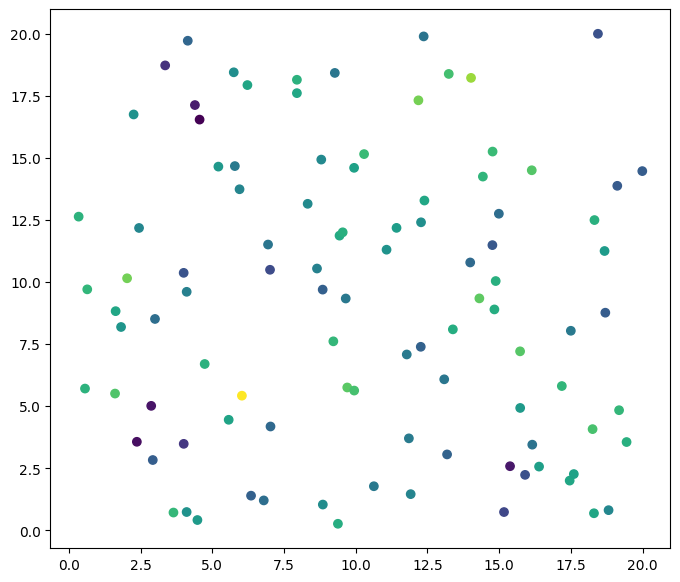

In [27]:
plt.figure(figsize=(8,7))
plt.scatter(X[:,0], X[:,1], c=Y);

In [38]:
def leave_one_out_univariate(X, Y, cov):
    
    n_points = (len(X)-1)//10
    A = np.arange((len(X)-1)//n_points*n_points)
    np.random.shuffle(A)
    A = A.reshape(((len(X)-1)//n_points,n_points))  
    
    Y_pred = []
    for i in range(0, X.shape[0]):
        X_aux = np.delete(X, i, axis=0)
        Y_aux = np.delete(Y, i, axis=0)
        Y_pred.append(nestedKriging(X[[i]], X_aux, Y_aux, A, cov))
    return np.array(Y_pred).reshape(-1)

In [29]:
def leave_one_out_univariate_kriging(X, Y, sigma, cov):
    Y_pred = []
    for i in range(0, X.shape[0]):
        sigma_aux = np.delete(np.delete(sigma, i, axis=0), i, axis=1)
        X_aux = np.delete(X, i, axis=0)
        Y_aux = np.delete(Y, i, axis=0)
        Y_pred.append(kriging(X[[i]], X_aux, Y_aux, sigma_aux, cov))
    return np.array(Y_pred).reshape(-1)

RMSE = 0.6154847897267645


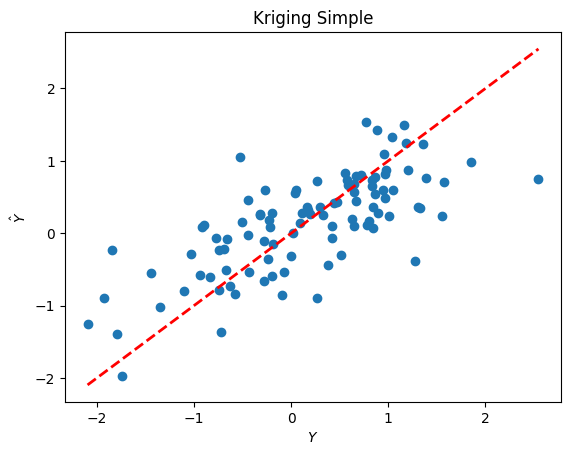

In [39]:
Y_pred = leave_one_out_univariate_kriging(X, Y, sigma, cov)

RMSE = root_mean_squared_error(Y, Y_pred)
print(f'{RMSE = }')

scatterplot(Y, Y_pred, title=r'Kriging Simple', xlabel=r'$Y$', ylabel=r'$\hat{Y}$')

RMSE = 0.6339473351601139


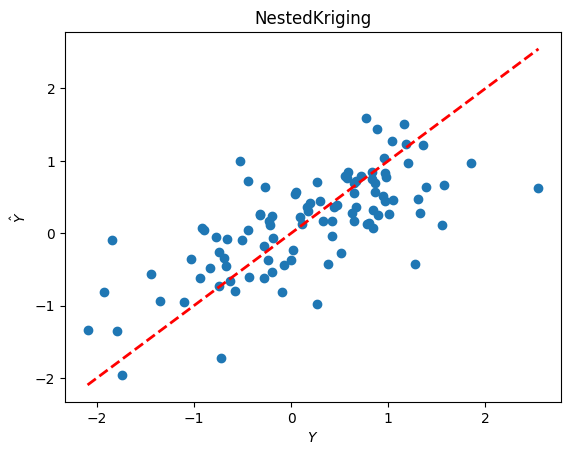

In [40]:
Y_pred = leave_one_out_univariate(X, Y, cov)

RMSE = root_mean_squared_error(Y, Y_pred)
print(f'{RMSE = }')

scatterplot(Y, Y_pred, title=r'NestedKriging', xlabel=r'$Y$', ylabel=r'$\hat{Y}$')